**Leveraging Machine Learning to Predict Dropout Likelihood in Higher Education**

Raquel Ana Bush, Brian Kade Betterton

First importing our necessary packages and data zipfile.

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
f_zip = 'https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip'
r = requests.get(f_zip, stream=True)
Dropout_zip = zipfile.ZipFile(io.BytesIO(r.content))
Dropout_zip.extractall() 

Then we take a peek at our dataset and start learning about it.

In [4]:
df = pd.read_csv('data.csv', sep=';')

df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


We see a lot of weird typos/symbols that do not need to be here. We also should think about encoding the target data, considering it has three different values.

In [5]:
df.shape

(4424, 37)

In [6]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

More exploration of the number of entries we have here, full list of column names.

In [7]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

Data types are all integers or floats, besides target data. Most likey no need for encoding with data type.

In [8]:
df.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

We check for null/missing values and find none. Next some text cleanup and encoding the target data. We also replace the "widowed" entry in the marital status with single for simplicty. 

In [9]:
df = pd.read_csv("data.csv", sep=';')
df.columns = [col.strip().replace('\t', '').replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for col in df.columns]

df['Target_encoded'] = df['Target'].map({
    'Dropout': 1,
    'Enrolled': 0,
    'Graduate': 0
})

In [10]:
X = df.drop(columns=['Target', 'Target_encoded'])
y = df['Target_encoded']
df['Marital_status'] = df['Marital_status'].replace({3: 1})
df.columns

Index(['Marital_status', 'Application_mode', 'Application_order', 'Course',
       'Daytime_evening_attendance', 'Previous_qualification',
       'Previous_qualification_grade', 'Nacionality', 'Mother's_qualification',
       'Father's_qualification', 'Mother's_occupation', 'Father's_occupation',
       'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
       'Age_at_enrollment', 'International',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem

In [11]:
# Define numeric encoding map
occupation_map = {
    # White-Collar -> 1
    1: 1, 2: 1, 3: 1, 4: 1, 112: 1, 114: 1, 121: 1, 122: 1, 123: 1,
    124: 1, 131: 1, 132: 1, 134: 1, 135: 1, 141: 1, 143: 1, 144: 1,

    # Blue-Collar -> 2
    7: 2, 8: 2, 171: 2, 172: 2, 174: 2, 175: 2, 181: 2, 182: 2, 183: 2,

    # Service -> 3
    5: 3, 6: 3, 9: 3, 151: 3, 152: 3, 153: 3, 154: 3,
    192: 3, 193: 3, 194: 3, 195: 3,

    # Military -> 4
    10: 4, 101: 4, 102: 4, 103: 4,

    # Other -> 0
    0: 0, 90: 0, 99: 0
}

# Apply encoding
df["Mother's occupation"] = df["Mother's_occupation"].map(occupation_map)
df["Father's occupation"] = df["Father's_occupation"].map(occupation_map)

# Rename columns
df.rename(columns={
    "Mother's occupation": "Mothers_encoded",
    "Father's occupation": "Fathers_encoded"
}, inplace=True)

Here, we are mapping the parents' profession data into smaller, simpler categories. This is because there is a massive slew of different occupation values that correspond to the numbers listed, and it's difficult to abstract and useful information from this. It could also over-complicate the model.  So we encode the values into smaller bins.

In [12]:
df.describe()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mother's_qualification,Father's_qualification,...,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target_encoded,Mothers_encoded,Fathers_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4396.000000,4418.000000
mean,1.176763,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.321203,2.033894,2.179719
std,0.603287,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.466991,1.043093,1.034092
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000,1.000000,1.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,0.000000,3.000000,2.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000,3.000000,3.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,1.000000,4.000000,4.000000


In [13]:
correlations = df.corr(numeric_only=True)['Target_encoded'].sort_values(ascending=False)
print(correlations)

Target_encoded                                  1.000000
Age_at_enrollment                               0.254215
Debtor                                          0.229407
Gender                                          0.203983
Application_mode                                0.198458
Marital_status                                  0.094551
Curricular_units_2nd_sem_without_evaluations    0.079901
Mother's_qualification                          0.064958
Curricular_units_1st_sem_without_evaluations    0.054230
Previous_qualification                          0.049379
Inflation_rate                                  0.027826
Father's_qualification                          0.018295
Unemployment_rate                               0.012980
Nacionality                                     0.008346
Educational_special_needs                       0.002806
International                                  -0.010360
Mother's_occupation                            -0.021999
Father's_occupation            

Here we are looking at the correlation values between each feature and the target data, so we can see which values are positively or negatively correlated with dropping out. Important to note that positive values here would be correlated to dropping out. 
A lot of these makes sense, things like age, debt, gender, marital status, parents qualifications, all would make sense with being linked to dropout rates. 

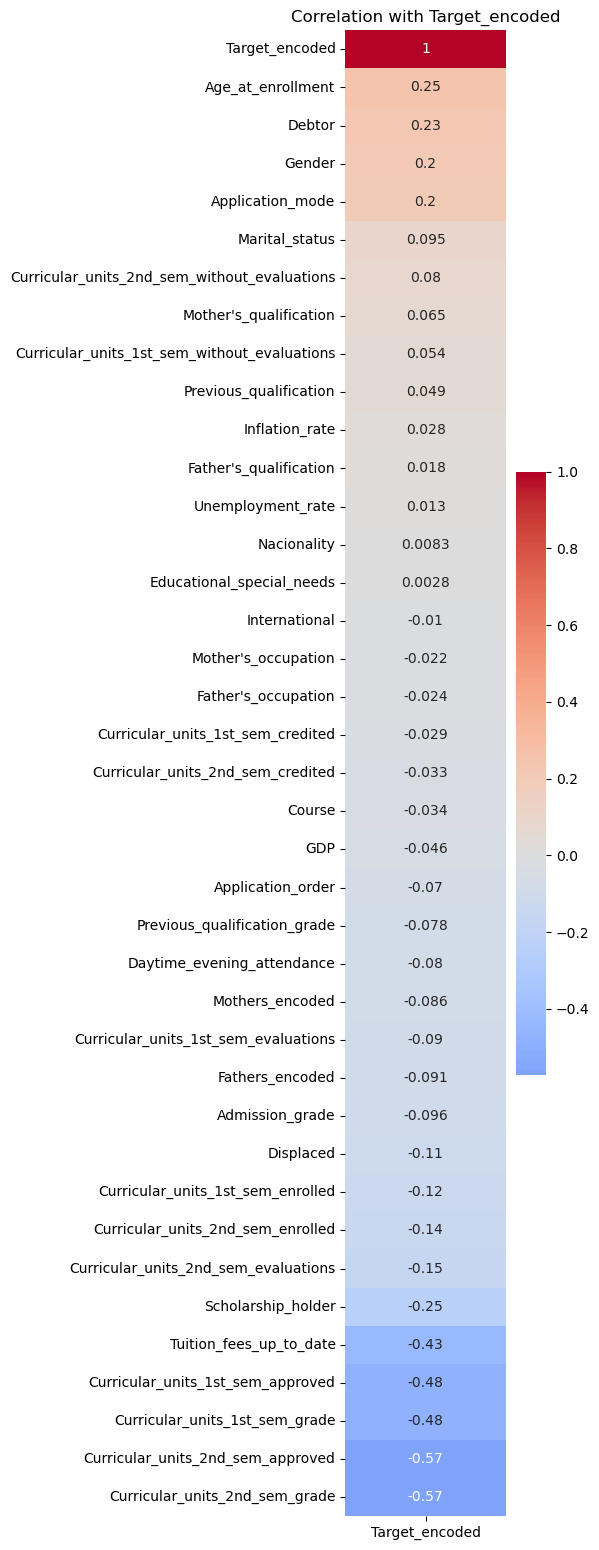

In [14]:
correlations = df.corr(numeric_only=True)['Target_encoded'].sort_values(ascending=False)

plt.figure(figsize=(6, len(correlations) * 0.4))  # Dynamically scales height
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', center=0, cbar=True)
plt.title("Correlation with Target_encoded")
plt.tight_layout()
plt.show()

Now let's get some boxplots comparing feature values for dropouts vs. non-dropouts.

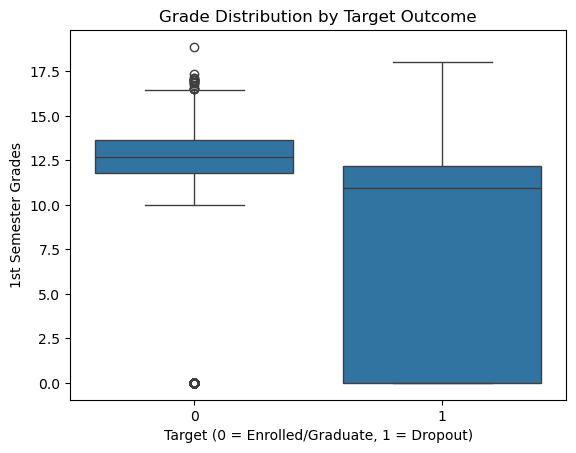

In [15]:
sns.boxplot(x='Target_encoded', y='Curricular_units_1st_sem_grade', data=df)
plt.xlabel('Target (0 = Enrolled/Graduate, 1 = Dropout)')
plt.ylabel('1st Semester Grades')
plt.title('Grade Distribution by Target Outcome')
plt.show()

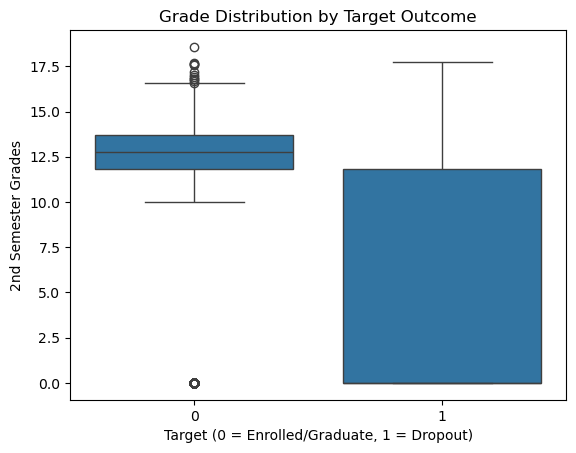

In [16]:
sns.boxplot(x='Target_encoded', y='Curricular_units_2nd_sem_grade', data=df)
plt.xlabel('Target (0 = Enrolled/Graduate, 1 = Dropout)')
plt.ylabel('2nd Semester Grades')
plt.title('Grade Distribution by Target Outcome')
plt.show()

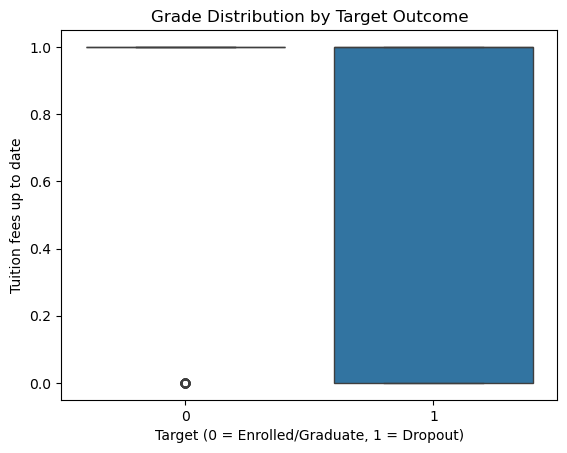

In [17]:
sns.boxplot(x='Target_encoded', y='Tuition_fees_up_to_date', data=df)
plt.xlabel('Target (0 = Enrolled/Graduate, 1 = Dropout)')
plt.ylabel('Tuition fees up to date')
plt.title('Grade Distribution by Target Outcome')
plt.show()

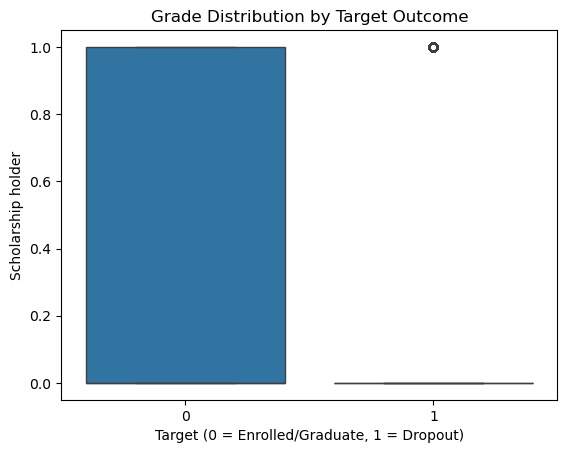

In [18]:
sns.boxplot(x='Target_encoded', y='Scholarship_holder', data=df)
plt.xlabel('Target (0 = Enrolled/Graduate, 1 = Dropout)')
plt.ylabel('Scholarship holder')
plt.title('Grade Distribution by Target Outcome')
plt.show()

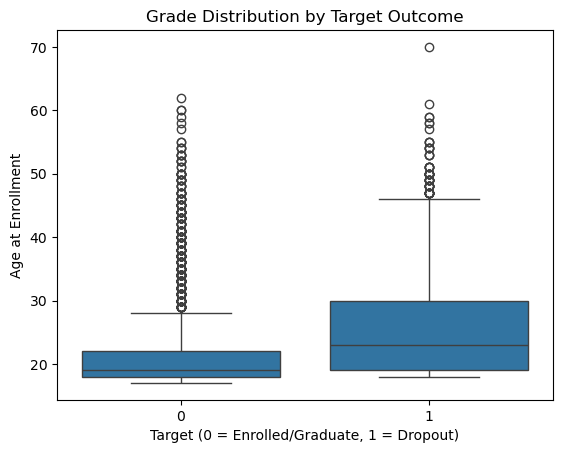

In [19]:
sns.boxplot(x='Target_encoded', y='Age_at_enrollment', data=df)
plt.xlabel('Target (0 = Enrolled/Graduate, 1 = Dropout)')
plt.ylabel('Age at Enrollment')
plt.title('Grade Distribution by Target Outcome')
plt.show()

Now we are generating density plots for each feature.

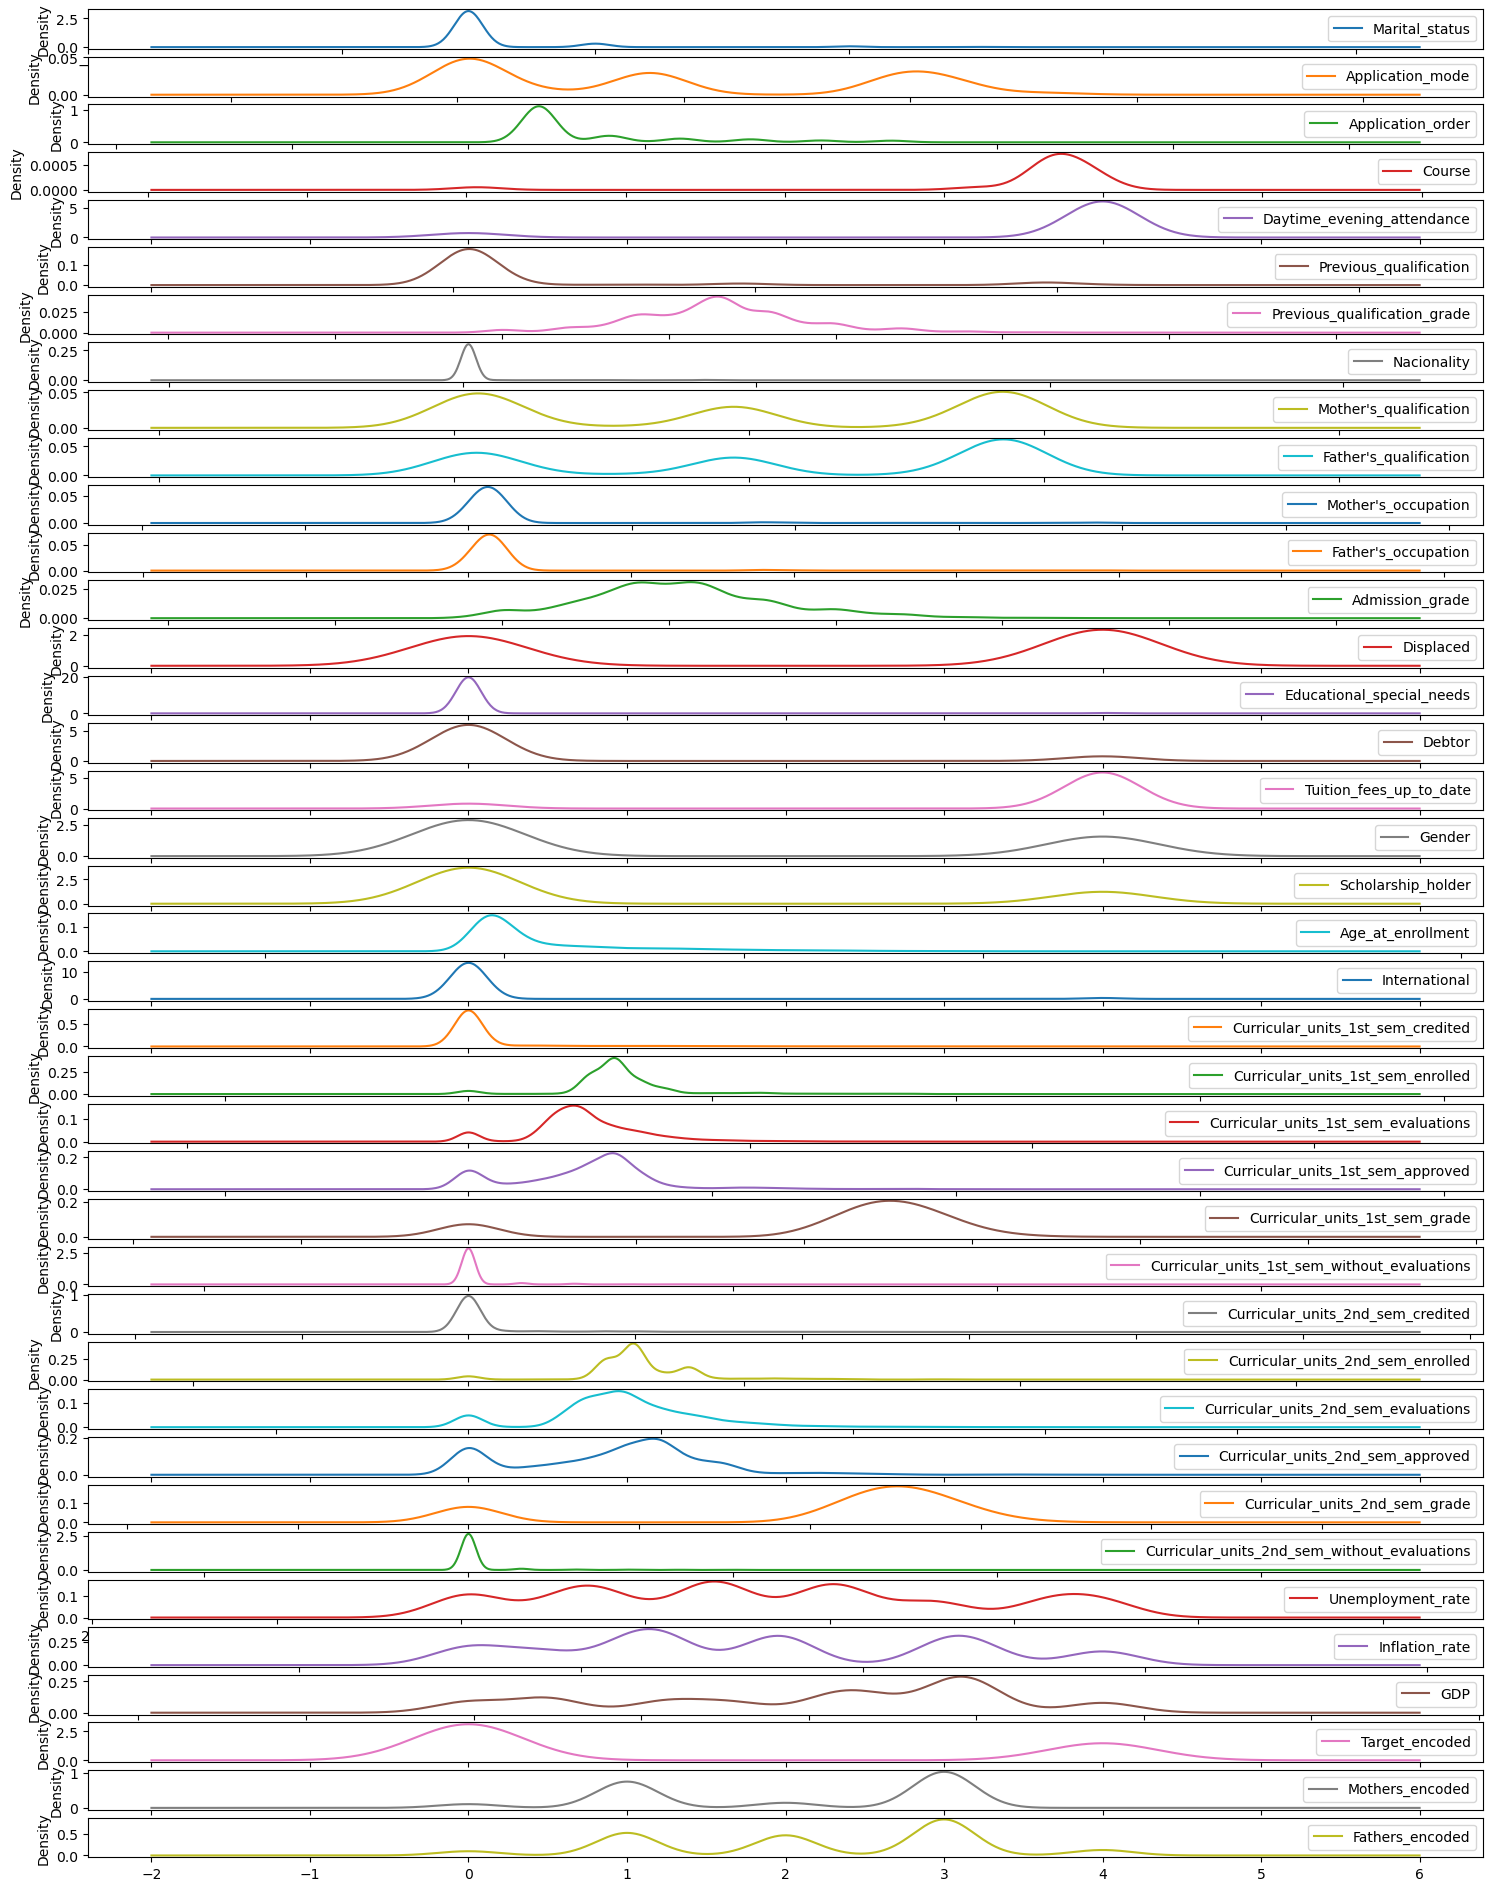

In [20]:
df.plot(kind='density', subplots=True, figsize=(18, 24), sharex=False)
plt.show()

Begin importing sklearn, setting train-test split.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This is our custom function for generating all of our model evaluation metrics. 

In [ ]:
def eval_metrics(test_labels, target_predicted_binary, target_predicted_prob=None):
    from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    import numpy as np

    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

    # Evaluation metrics:
    Sensitivity = TP / (TP + FN) * 100
    Specificity = TN / (TN + FP) * 100
    Precision   = TP / (TP + FP) * 100
    NPV         = TN / (TN + FN) * 100
    FPR         = FP / (FP + TN) * 100
    FNR         = FN / (TP + FN) * 100
    FDR         = FP / (TP + FP) * 100
    ACC         = (TP + TN) / (TP + FP + FN + TN) * 100

    print(f"Sensitivity or TPR: {Sensitivity:.2f}%")
    print(f"Specificity or TNR: {Specificity:.2f}%")
    print(f"Precision: {Precision:.2f}%")
    print(f"Negative Predictive Value: {NPV:.2f}%")
    print(f"False Positive Rate: {FPR:.2f}%")
    print(f"False Negative Rate: {FNR:.2f}%")
    print(f"False Discovery Rate: {FDR:.2f}%")
    print(f"Accuracy: {ACC:.2f}%")

    # Confusion matrix plot:
    cm = confusion_matrix(test_labels, target_predicted_binary)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC/AUC:
    if target_predicted_prob is not None:
        auc_score = roc_auc_score(test_labels, target_predicted_prob)
        print(f"Validation AUC: {auc_score:.4f}")

        fpr, tpr, _ = roc_curve(test_labels, target_predicted_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()


# Training & checking metrics for XGBoost:

In [24]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Sensitivity or TPR: 76.76%
Specificity or TNR: 93.34%
Precision: 84.50%
Negative Predictive Value: 89.47%
False Positive Rate: 6.66%
False Negative Rate: 23.24%
False Discovery Rate: 15.50%
Accuracy: 88.02%


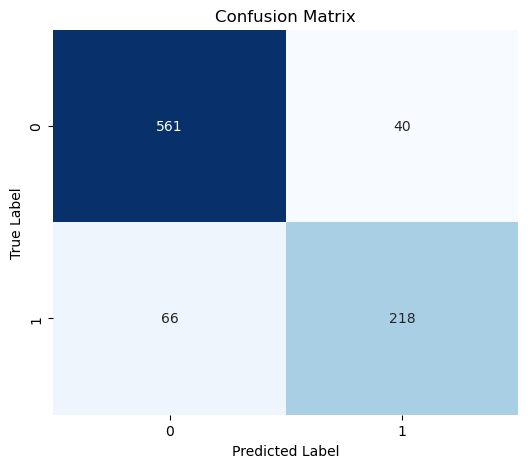

Validation AUC: 0.9286


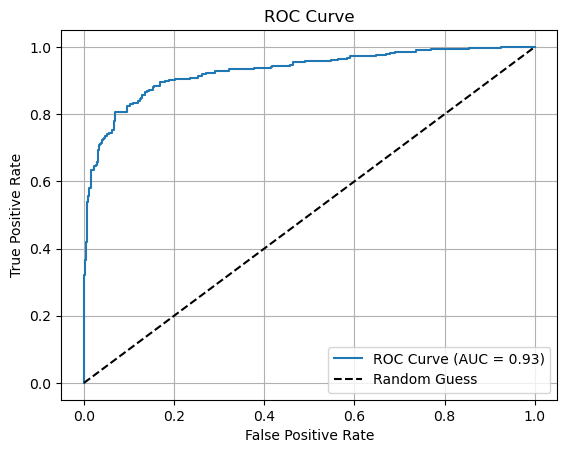

In [25]:
train_acc = xgb_model.score(X_train_scaled, y_train)
test_acc = xgb_model.score(X_test_scaled, y_test)

# Predict labels (0/1) and probabilities for positive class
y_pred = xgb_model.predict(X_test_scaled)                     # binary labels
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]    # probabilities

eval_metrics(y_test, y_pred, y_pred_prob)

Curricular_units_2nd_sem_approved    0.247646
Tuition_fees_up_to_date              0.149531
Curricular_units_1st_sem_enrolled    0.067115
Curricular_units_1st_sem_approved    0.035683
Debtor                               0.032073
Scholarship_holder                   0.028993
Curricular_units_2nd_sem_credited    0.026985
Curricular_units_2nd_sem_enrolled    0.026671
Curricular_units_1st_sem_credited    0.022744
Age_at_enrollment                    0.020107
dtype: float32


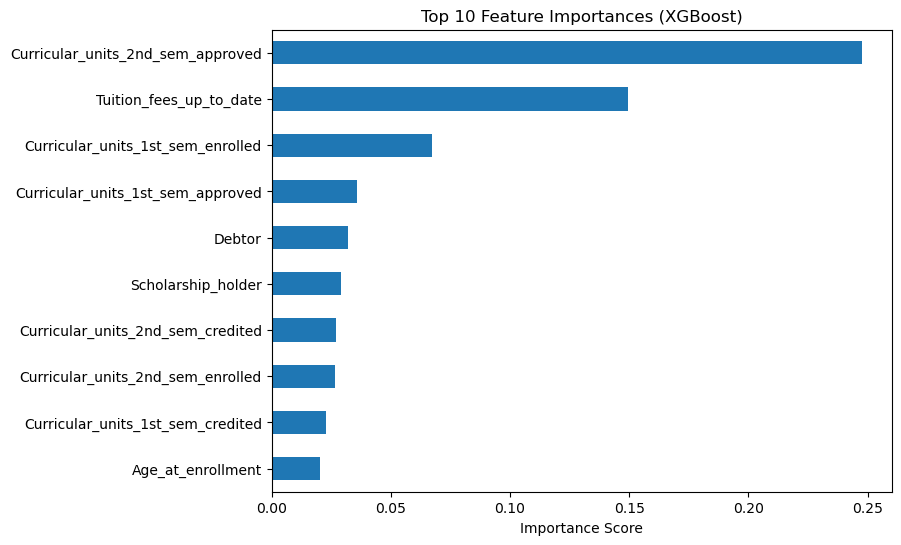

In [ ]:
# get feature importances from the trained model
importances = xgb_model.feature_importances_

# create a Series with feature names as index
feature_importance_series = pd.Series(importances, index=X.columns)

# sort and select top 10:
top_10_features = feature_importance_series.sort_values(ascending=False).head(10)
print(top_10_features)

# bar plot:
top_10_features.plot(kind='barh', title='Top 10 Feature Importances (XGBoost)', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.show()

# Hyperparameter tuning and evaluation for XGBoost:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(eval_metric='mlogloss',  
                          objective='binary:logistic',
                          random_state=42)

param_distributions = {
    'alpha': [i for i in range(0, 101)],                
    'min_child_weight': [i for i in range(1, 6)],        
    'subsample': [i / 10 for i in range(5, 11)],         
    'eta': [i / 10 for i in range(1, 4)],                
}

In [28]:
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    scoring='accuracy',  
    n_iter=20,           
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Sensitivity or TPR: 73.59%
Specificity or TNR: 94.18%
Precision: 85.66%
Negative Predictive Value: 88.30%
False Positive Rate: 5.82%
False Negative Rate: 26.41%
False Discovery Rate: 14.34%
Accuracy: 87.57%


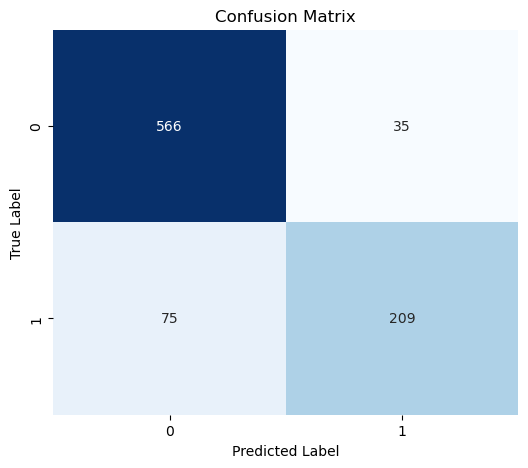

Validation AUC: 0.9292


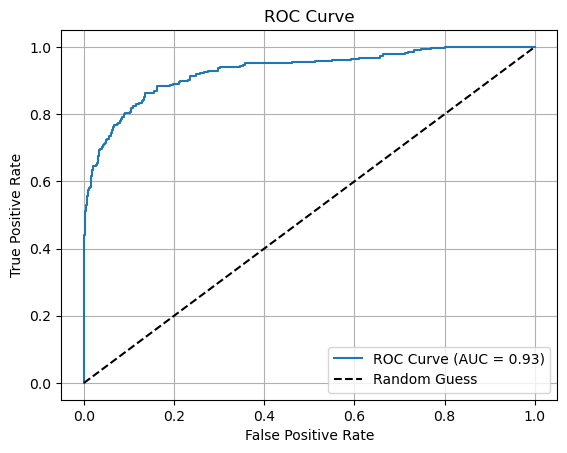

In [29]:
search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_
best_params = search.best_params_

train_acc = best_model.score(X_train_scaled, y_train)
test_acc = best_model.score(X_test_scaled, y_test)


y_pred = best_model.predict(X_test_scaled)                    
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]   

eval_metrics(y_test, y_pred, y_pred_prob)         

# Training & checking metrics for Random Forest:

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Sensitivity or TPR: 72.18%
Specificity or TNR: 95.51%
Precision: 88.36%
Negative Predictive Value: 87.90%
False Positive Rate: 4.49%
False Negative Rate: 27.82%
False Discovery Rate: 11.64%
Accuracy: 88.02%


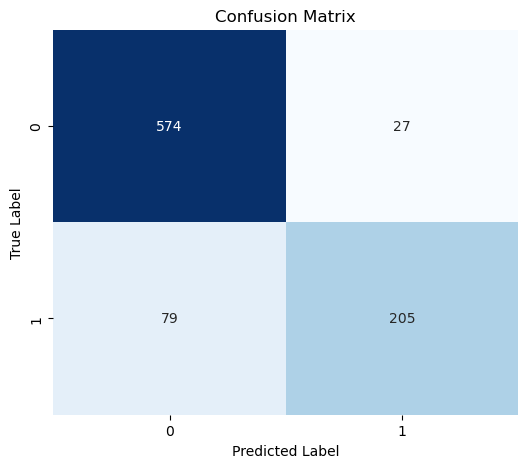

Validation AUC: 0.9300


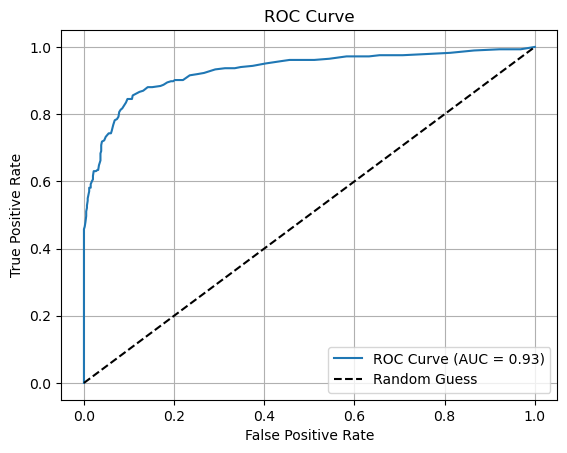

In [31]:
train_acc = rf_model.score(X_train_scaled, y_train)
test_acc = rf_model.score(X_test_scaled, y_test)

y_pred = rf_model.predict(X_test_scaled)                     
y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]    

eval_metrics(y_test, y_pred, y_pred_prob)

# Hyperparamter tuning for Random Forest

In [32]:
from sklearn.model_selection import RandomizedSearchCV


rf_model = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],         
    'max_depth': [None, 10, 20, 30, 40, 50],           
    'min_samples_split': [2, 5, 10],                   
    'min_samples_leaf': [1, 2, 4],                     
    'max_features': ['auto', 'sqrt', 'log2'],          
    'bootstrap': [True, False]                         
}

In [33]:
search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Sensitivity or TPR: 73.59%
Specificity or TNR: 94.51%
Precision: 86.36%
Negative Predictive Value: 88.34%
False Positive Rate: 5.49%
False Negative Rate: 26.41%
False Discovery Rate: 13.64%
Accuracy: 87.80%


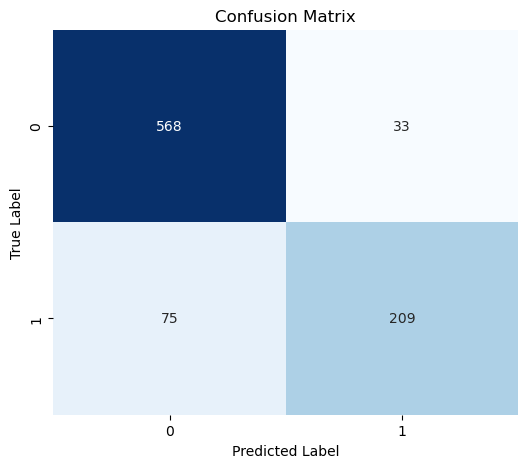

Validation AUC: 0.9330


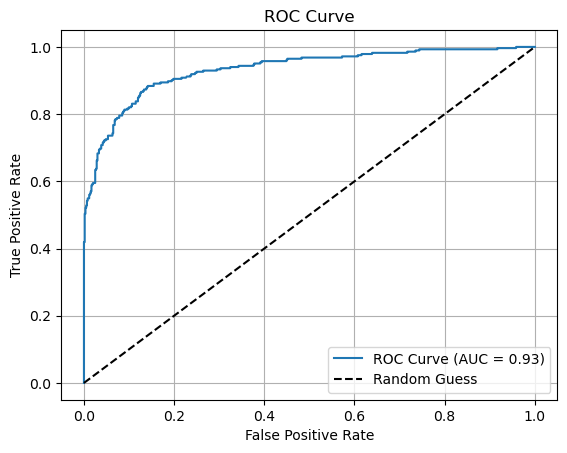

In [ ]:
search.fit(X_train_scaled, y_train)

best_rf_model = search.best_estimator_
best_rf_params = search.best_params_

train_acc = best_rf_model.score(X_train_scaled, y_train)
test_acc = best_rf_model.score(X_test_scaled, y_test)

print("Best Parameters:", best_rf_params)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred_prob = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # we use [:, 1] for positive class

eval_metrics(y_test, y_pred, y_pred_prob)         

# Training & checking accuracy for Decision Tree:

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

Sensitivity or TPR: 73.59%
Specificity or TNR: 94.51%
Precision: 86.36%
Negative Predictive Value: 88.34%
False Positive Rate: 5.49%
False Negative Rate: 26.41%
False Discovery Rate: 13.64%
Accuracy: 87.80%


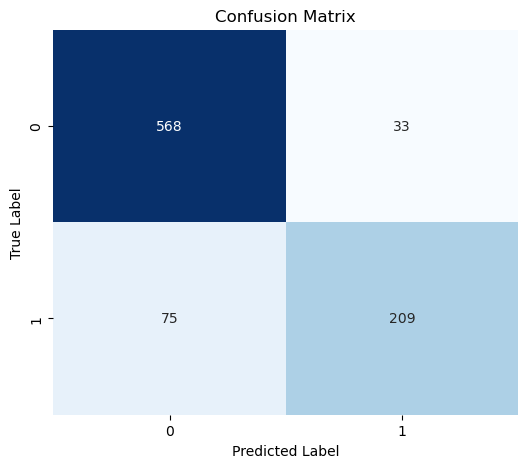

Validation AUC: 0.9330


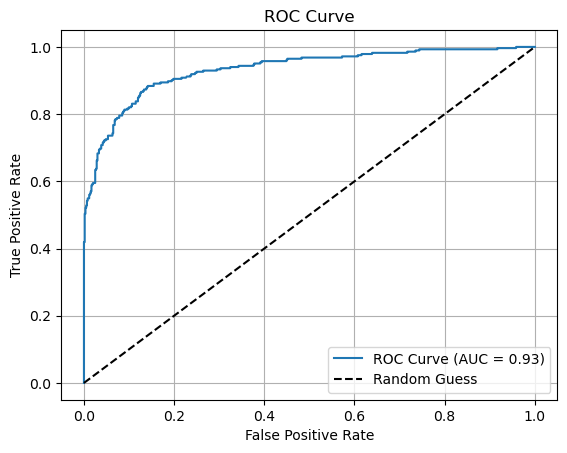

In [36]:
train_acc = dt_model.score(X_train_scaled, y_train)
test_acc = dt_model.score(X_test_scaled, y_test)

eval_metrics(y_test, y_pred, y_pred_prob)

# Hyperparameter Tuning for Decision Tree:

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Sensitivity or TPR: 63.38%
Specificity or TNR: 96.01%
Precision: 88.24%
Negative Predictive Value: 84.73%
False Positive Rate: 3.99%
False Negative Rate: 36.62%
False Discovery Rate: 11.76%
Accuracy: 85.54%


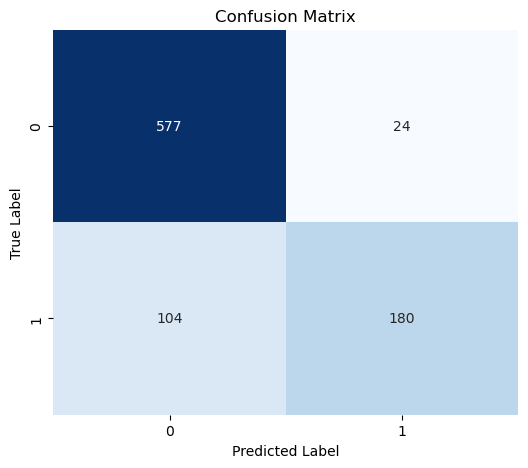

Validation AUC: 0.8825


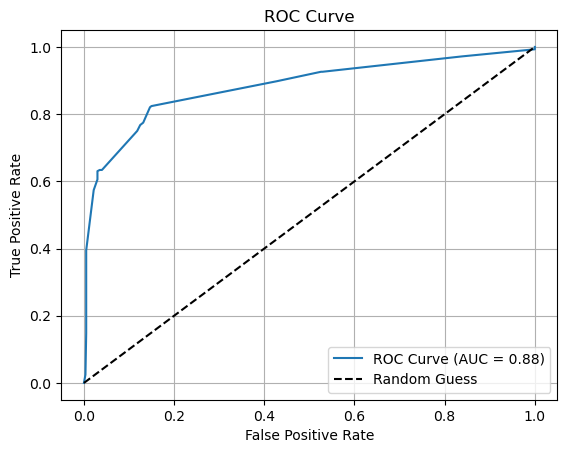

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt_model = DecisionTreeClassifier(random_state=42)


param_distributions = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  
    'splitter': ['best', 'random']
}

search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)

best_dt_model = search.best_estimator_
best_dt_params = search.best_params_

train_acc = best_dt_model.score(X_train_scaled, y_train)
test_acc = best_dt_model.score(X_test_scaled, y_test)

y_pred = best_dt_model.predict(X_test_scaled)
y_pred_prob = best_dt_model.predict_proba(X_test_scaled)[:, 1]

eval_metrics(y_test, y_pred, y_pred_prob)

# Training & checking accuracy for Logistic Regression:

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
Sensitivity or TPR: 73.59%
Specificity or TNR: 96.01%
Precision: 89.70%
Negative Predictive Value: 88.50%
False Positive Rate: 3.99%
False Negative Rate: 26.41%
False Discovery Rate: 10.30%
Accuracy: 88.81%


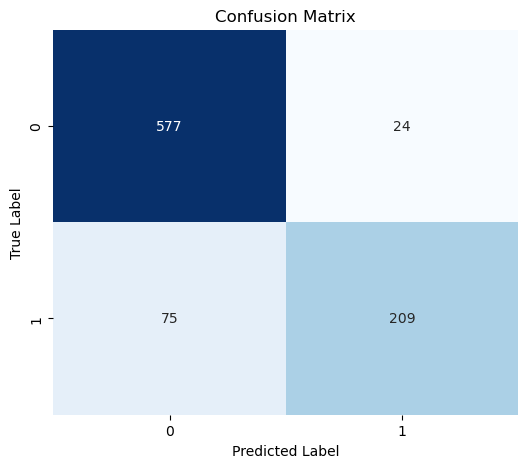

Validation AUC: 0.9266


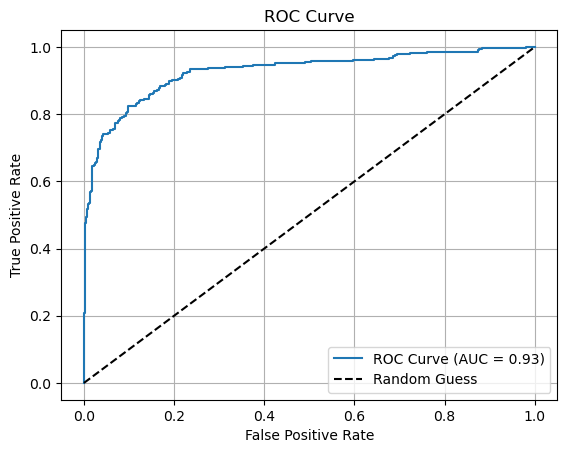

In [ ]:
import statsmodels.api as sm

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

logit_model = sm.Logit(y_train, X_train_scaled)
result = logit_model.fit()

y_pred_prob = result.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

eval_metrics(y_test, y_pred, y_pred_prob)

# Hyperparameter tuning for Logistic Regression, running the model with different threshold values

For logistic regression, we are approaching this differently. We tune by altering the decision threshold to see which may provide better sensitivity without too much sacrifice to specificity.

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
The boundary value is now 0.2:
Sensitivity or TPR: 89.08%
Specificity or TNR: 81.53%
Precision: 69.51%
Negative Predictive Value: 94.05%
False Positive Rate: 18.47%
False Negative Rate: 10.92%
False Discovery Rate: 30.49%
Accuracy: 83.95%


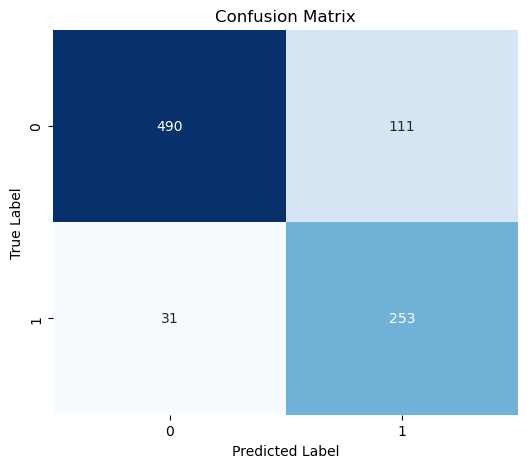

Validation AUC: 0.9266


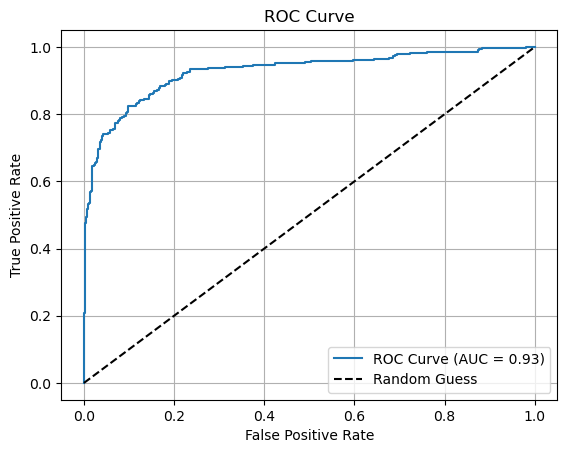

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
The boundary value is now 0.4:
Sensitivity or TPR: 78.52%
Specificity or TNR: 92.01%
Precision: 82.29%
Negative Predictive Value: 90.07%
False Positive Rate: 7.99%
False Negative Rate: 21.48%
False Discovery Rate: 17.71%
Accuracy: 87.68%


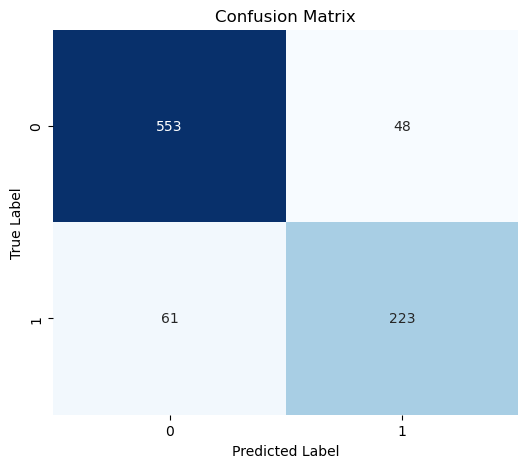

Validation AUC: 0.9266


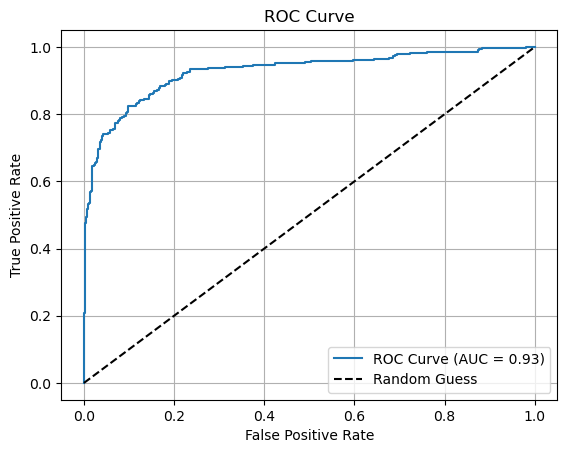

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
The boundary value is now 0.6:
Sensitivity or TPR: 68.31%
Specificity or TNR: 96.84%
Precision: 91.08%
Negative Predictive Value: 86.61%
False Positive Rate: 3.16%
False Negative Rate: 31.69%
False Discovery Rate: 8.92%
Accuracy: 87.68%


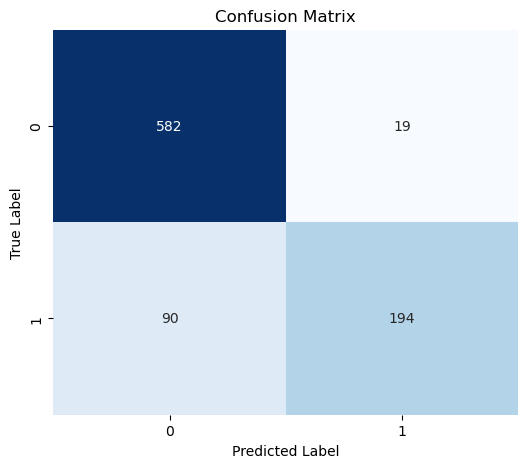

Validation AUC: 0.9266


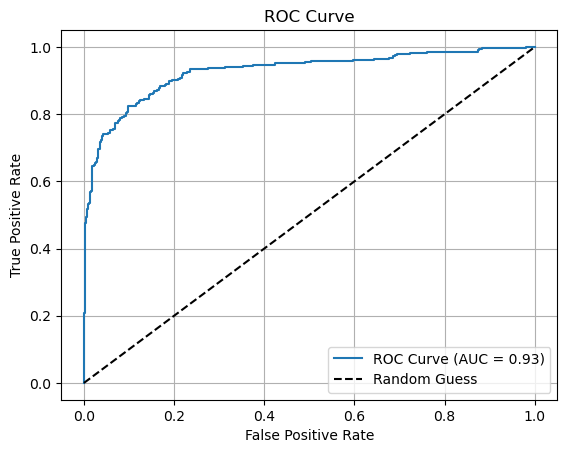

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
The boundary value is now 0.75:
Sensitivity or TPR: 62.68%
Specificity or TNR: 98.17%
Precision: 94.18%
Negative Predictive Value: 84.77%
False Positive Rate: 1.83%
False Negative Rate: 37.32%
False Discovery Rate: 5.82%
Accuracy: 86.78%


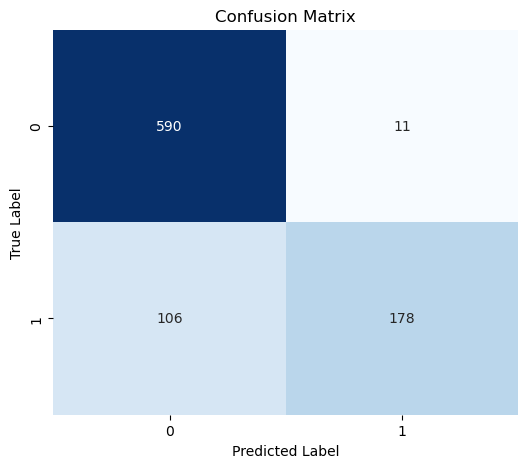

Validation AUC: 0.9266


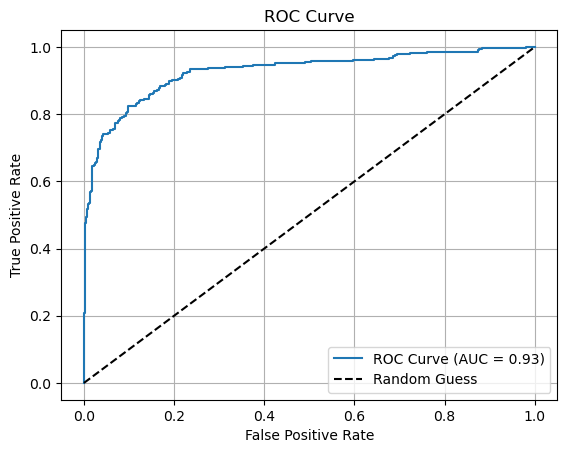

Optimization terminated successfully.
         Current function value: 0.313750
         Iterations 7
The boundary value is now 0.8:
Sensitivity or TPR: 58.10%
Specificity or TNR: 98.17%
Precision: 93.75%
Negative Predictive Value: 83.22%
False Positive Rate: 1.83%
False Negative Rate: 41.90%
False Discovery Rate: 6.25%
Accuracy: 85.31%


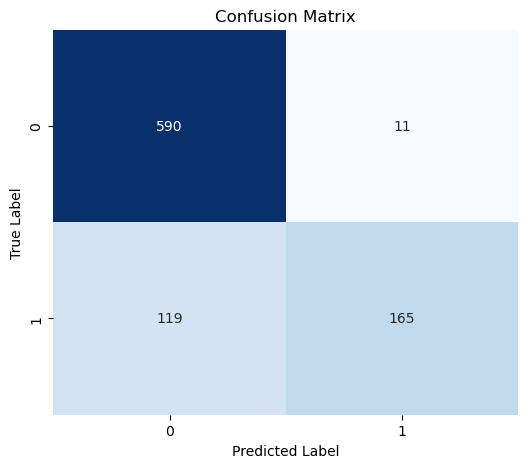

Validation AUC: 0.9266


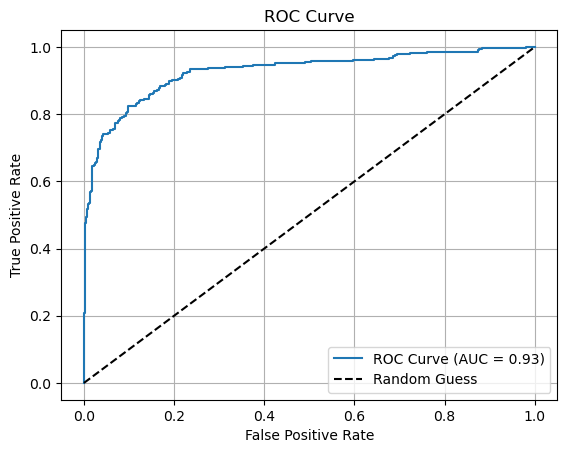

In [39]:
for val in [0.2, 0.4, 0.6, 0.75, 0.8]:
    
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)

    logit_model = sm.Logit(y_train, X_train_scaled)
    result = logit_model.fit()

    y_pred_prob = result.predict(X_test_scaled)
    y_pred = (y_pred_prob > val).astype(int)
    print(f"The boundary value is now {val}:")
    eval_metrics(y_test, y_pred, y_pred_prob)